In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q -U tensorflow-text
!pip install -q tf-models-official

     |████████████████████████████████| 4.9 MB 5.5 MB/s 
     |████████████████████████████████| 1.8 MB 5.2 MB/s 
     |████████████████████████████████| 352 kB 46.8 MB/s 
     |████████████████████████████████| 99 kB 9.0 MB/s 
     |████████████████████████████████| 47.6 MB 101 kB/s 
     |████████████████████████████████| 596 kB 44.0 MB/s 
     |████████████████████████████████| 1.2 MB 41.0 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 213 kB 46.8 MB/s 
     |████████████████████████████████| 90 kB 9.5 MB/s 
     |████████████████████████████████| 1.1 MB 50.7 MB/s 


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, log_loss, roc_curve, auc, accuracy_score
from sklearn.metrics import classification_report
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
#from tensorflow.compat.v1 import ConfigProto
#from tensorflow.compat.v1 import InteractiveSession
#config = ConfigProto()
#config.gpu_options.allow_growth = True
#session = InteractiveSession(config=config)
tf.random.set_seed(1)
np.random.seed(1)

In [ ]:
data_root = r'/content/drive/My Drive/data/fake_news/news.csv'
TARGET_NAME = 'label'

In [ ]:
df = pd.read_csv(data_root)

In [ ]:
class_names = {'REAL': 0, 'FAKE': 1}
df.label = df.label.map(class_names)

In [ ]:
df.label.value_counts(normalize=True)

0    0.500552
1    0.499448
Name: label, dtype: float64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 198.1+ KB


In [ ]:
df.sample(5)

,Unnamed: 0,title,text,label
3553,4002,Pentagon weighs using force to protect US-back...,Senior U.S. military leaders and defense offic...,0
5826,7941,UK announces new troop deployment near Russia'...,Military British Defense Secretary Michael Fal...,1
6140,10312,Dog Waited Faithfully For Over A Month After H...,There have been horror stories of families lea...,1
2487,362,Defense Secretary Carter endorses 3-year timel...,Defense Secretary Ash Carter on Wednesday endo...,0
1720,7878,Hilarious Cartoon Reveals 2016 Political Versi...,Pinterest \nC.E. Dyer writes that the disaster...,1


In [ ]:
df.iloc[0, 2]

'Daniel Greenfield, a Shillman Journalism Fellow at the Freedom Center, is a New York writer focusing on radical Islam. \nIn the final stretch of the election, Hillary Rodham Clinton has gone to war with the FBI. \nThe word “unprecedented” has been thrown around so often this election that it ought to be retired. But it’s still unprecedented for the nominee of a major political party to go war with the FBI. \nBut that’s exactly what Hillary and her people have done. Coma patients just waking up now and watching an hour of CNN from their hospital beds would assume that FBI Director James Comey is Hillary’s opponent in this election. \nThe FBI is under attack by everyone from Obama to CNN. Hillary’s people have circulated a letter attacking Comey. There are currently more media hit pieces lambasting him than targeting Trump. It wouldn’t be too surprising if the Clintons or their allies were to start running attack ads against the FBI. \nThe FBI’s leadership is being warned that the entir

In [ ]:
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer
from bs4 import BeautifulSoup as bs

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# optionally preprocess
stop = stopwords.words('english')

def preprocessor(text, is_soup=False):
    if is_soup:
        soup = bs(text, 'html.parser').getText()
    text = re.sub('Subject: ', '', text)
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower())
    text = re.sub(r'[^\w]', ' ', text)
    text = [w for w in text.split() if w not in stop]
    text = [re.sub(r"[^a-zA-Z0-9]+", '', k) for k in text]
    return re.sub(' +', ' ', ' '.join(text))

def snow_stem(text):
    snow_stemmer = SnowballStemmer(language='english')
    new_text = ''
    for word in text.split():
        new_text += snow_stemmer.stem(word) + ' '
    return new_text

df['text'] = df['text'].apply(lambda x: snow_stem(preprocessor(x, is_soup=True)))

In [ ]:
df['text'][0] # if preprocessing applied

'daniel greenfield shillman journal fellow freedom center new york writer focus radic islam final stretch elect hillari rodham clinton gone war fbi word unpreced thrown around often elect ought retir still unpreced nomine major polit parti go war fbi exact hillari peopl done coma patient wake watch hour cnn hospit bed would assum fbi director jame comey hillari oppon elect fbi attack everyon obama cnn hillari peopl circul letter attack comey current media hit piec lambast target trump surpris clinton alli start run attack ad fbi fbi leadership warn entir left wing establish form lynch mob continu go hillari fbi credibl attack media democrat preemptiv head result investig clinton foundat hillari clinton covert struggl fbi agent obama doj peopl gone explos public new york time compar comey j edgar hoover bizarr headlin jame comey role recal hoover fbi fair practic admit front spout nonsens boston globe publish column call comey resign outdon time editori claim scandal realli attack women

In [ ]:
X, y = df['text'], df[TARGET_NAME]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, stratify=y, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, stratify=y_train, random_state=1)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 1

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE) 
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [ ]:
for text_batch, label_batch in train_ds.take(1):
    for i in range(3):
        print(f'News: {text_batch.numpy()[i]}')
        label = label_batch.numpy()[i]
        print(f'Class: {label}')

News: b'Washington The Democratic candidates for president gathered in Des Moines, Iowa, for their second debate Saturday, and CNN\'s Reality Check team spent the night putting their statements and assertions to the test.\n\nThe team of reporters, researchers and editors across CNN selected key statements and rated them: True; Mostly True; True, but Misleading; False; or It\'s Complicated.\n\nPrevious CNN Reality Check coverage of the Democratic and Republican candidates can be found here . This story will be updated throughout the night.\n\nFormer Secretary of State Hillary Clinton threw her support behind a $12 hourly minimum wage at Saturday\'s debate. That\'s lower than the $15 an hour minimum backed by Vermont Senator Bernie Sanders and former Maryland Governor Martin O\'Malley, as well many progressive activists nationwide.\n\nClinton defended her stance, saying: "If you go to $12, it would be the highest historical average we\'ve ever had." That\'s the "smartest" way to move for

In [ ]:
bert_model_name = 'talking-heads_base' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
text_test = ['this is such an awful fake newspaper!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')
# 101 - [CLS], 102 - [SEP]

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 9643 8275 3780  999  102    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 1 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[-0.00288393  0.15197012 -0.2290798  -0.10988649 -0.380047   -0.4348623
  0.36220393 -0.18808821 -0.03941035  0.34778276 -0.40727776 -0.2613006 ]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[ 0.10978686  0.44504368 -0.33827427 ... -0.9016863  -1.1572604
   0.15197876]
 [ 1.0635219  -0.07394315 -0.72847736 ...  0.28394127 -0.41150433
   0.50810486]
 [-0.30406827  0.32775483 -1.1034219  ... -0.91373205 -0.3654796
  -0.04231863]
 ...
 [-0.4557755  -0.3042446  -1.7202263  ... -0.84863156 -0.77677685
   0.35881174]
 [-0.68422174 -1.2505833  -1.4282373  ... -0.08705665  0.04391871
   0.3931777 ]
 [-0.6743191  -1.2151079  -1.4704382  ... -0.0541585   0.04205815
   0.47075367]]


In [ ]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['sequence_output'] # ['pooled_output'] # if next layer is linear (whole encoded sentence), otherwise sequence_output (all encoded tokens)
    conv = tf.keras.layers.Conv1D(64, (2), activation='relu')(net)
    conv = tf.keras.layers.Conv1D(128, (2), activation='relu')(conv)
    pool = tf.keras.layers.GlobalMaxPool1D()(conv) # or GlobalAveragePool1D
    drop = tf.keras.layers.Dropout(0.25)(pool)
    net = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(5e-5))(drop)
    net = tf.keras.layers.Dropout(0.25)(net)
    net = tf.keras.layers.Dense(2, activation='softmax', name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(bert_raw_result)  # meaningless output, just illustration

tf.Tensor([[0.4276169  0.57238305]], shape=(1, 2), dtype=float32)


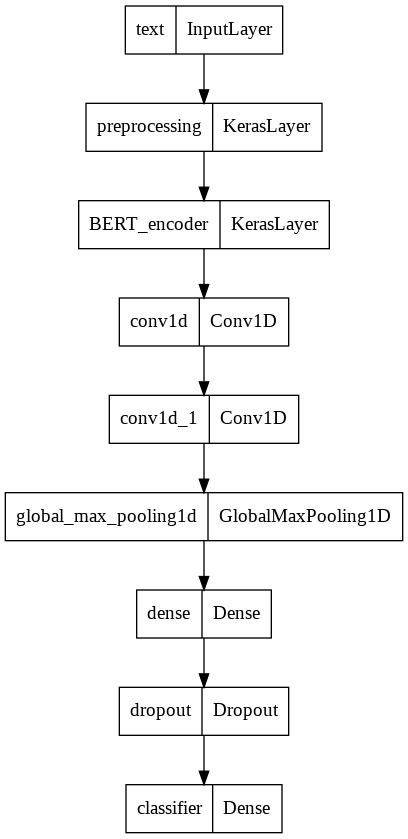

In [ ]:
tf.keras.utils.plot_model(classifier_model)

In [ ]:
checkpoint_path = '.'
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) # BinaryCrossentropy if output from dense=1
metrics = [tf.metrics.SparseCategoricalAccuracy('accuracy'),] # BinaryAccuracy()
epochs = 15
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,  # try custom lr_scheduler, see translator transformer
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=False), # save best model
             tf.keras.callbacks.ReduceLROnPlateau(patience=4),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
             tf.keras.callbacks.TensorBoard(log_dir="logs"),
            ]

In [ ]:
classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# classifier_model.layers[2].trainable = False  # freeze bert weights if not training bert

In [ ]:
history = classifier_model.fit(train_ds, epochs=epochs, verbose=1, validation_data=val_ds) # callbacks=callbacks,

Epoch 1/15
152/152 [==============================] - 493s 3s/step - loss: 0.7894 - accuracy: 0.5633 - val_loss: 0.3599 - val_accuracy: 0.8646
Epoch 2/15
152/152 [==============================] - 462s 3s/step - loss: 0.2128 - accuracy: 0.9269 - val_loss: 0.1130 - val_accuracy: 0.9610
Epoch 3/15
152/152 [==============================] - 461s 3s/step - loss: 0.0856 - accuracy: 0.9800 - val_loss: 0.1176 - val_accuracy: 0.9722
Epoch 4/15
152/152 [==============================] - 460s 3s/step - loss: 0.0447 - accuracy: 0.9911 - val_loss: 0.2542 - val_accuracy: 0.9592
Epoch 5/15
152/152 [==============================] - 459s 3s/step - loss: 0.0354 - accuracy: 0.9934 - val_loss: 0.2403 - val_accuracy: 0.9647
Epoch 6/15
152/152 [==============================] - 461s 3s/step - loss: 0.0244 - accuracy: 0.9965 - val_loss: 0.2172 - val_accuracy: 0.9647
Epoch 7/15
152/152 [==============================] - 459s 3s/step - loss: 0.0128 - accuracy: 0.9992 - val_loss: 0.3171 - val_accuracy: 0.9629

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

30/30 [==============================] - 31s 1s/step - loss: 0.2819 - accuracy: 0.9737
Loss: 0.2818622589111328
Accuracy: 0.9737119078636169


In [ ]:
saved_model_path = r'/content/drive/My Drive/data/fake_news/'
classifier_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/fake_news/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/fake_news/assets


In [ ]:
# callibrate probas
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

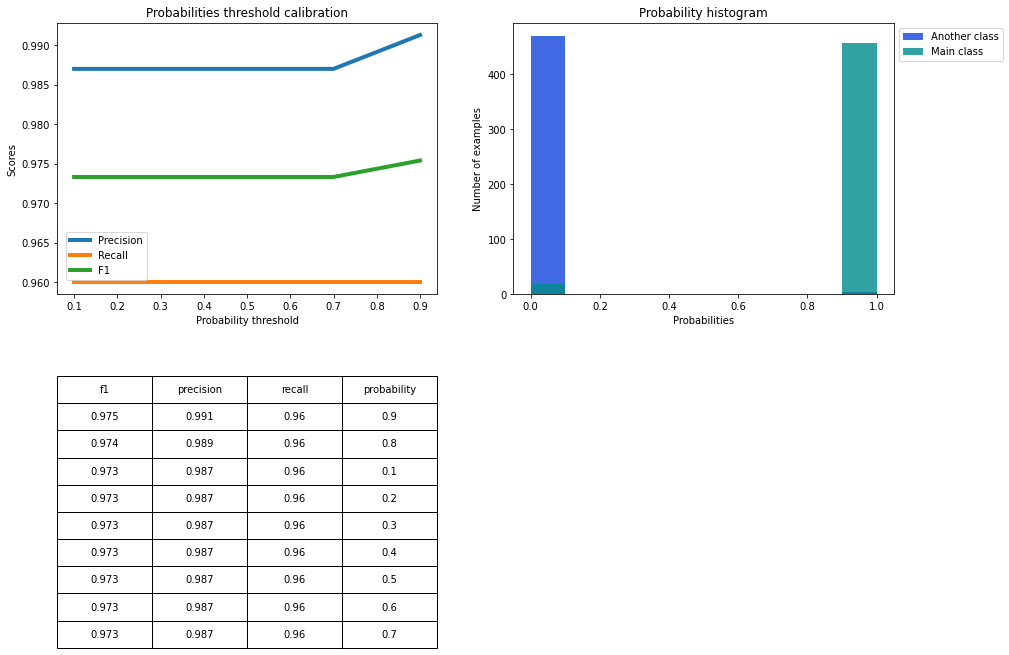

In [ ]:
show_proba_calibration_plots(classifier_model.predict(test_ds)[:,1], y_test)